In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.preprocessing.image import load_img
from keras.applications.resnet50 import preprocess_input
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
BASE_DIR = "C:\\Users\\91939\\Downloads\\face\\UTKFace"

In [3]:
image_paths = []
age_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

  0%|          | 0/23708 [00:00<?, ?it/s]

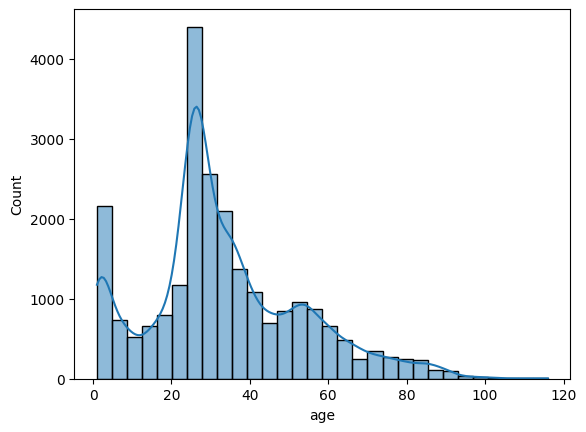

In [4]:
# Convert to DataFrame
df = pd.DataFrame({'image': image_paths, 'age': age_labels})
sns.histplot(df['age'], bins=30, kde=True)
plt.show()

In [5]:
# Feature extraction
def extract_features(images):
    features = []
    for image in tqdm(images):
        try:
            img = load_img(image, target_size=(128, 128), color_mode='rgb')
            img = np.array(img)
            features.append(img)
        except Exception as e:
            print(f"Error loading image {image}: {e}")
    features = np.array(features)
    print(f"Final features shape: {features.shape}")
    return features

In [6]:
X = extract_features(df['image'])
X = X / 255.0  # Normalize
y_age = np.array(df['age'])

  0%|          | 0/23708 [00:00<?, ?it/s]

Final features shape: (23708, 128, 128, 3)


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_age, test_size=0.2, random_state=42)

In [8]:
# Model definition
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

In [9]:
#pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

In [10]:
# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

In [11]:
x = Flatten()(base_model.output)
output = Dense(1, activation='linear')(x)  # Age prediction
model = Model(inputs=inputs, outputs=output)

In [12]:
# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,620,481 (90.10 MB)

 Trainable params: 32,769 (128.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('age_detection_model.keras', save_best_only=True)
]

In [14]:
# Train model
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 478s 955ms/step - loss: 529.7813 - mae: 17.4172 - val_loss: 405.5756 - val_mae: 15.4972
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 10079s 21s/step - loss: 381.8369 - mae: 14.9504 - val_loss: 402.8212 - val_mae: 14.9571
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 570s 1s/step - loss: 377.7151 - mae: 14.8786 - val_loss: 386.9844 - val_mae: 14.8367
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 717s 2s/step - loss: 363.7667 - mae: 14.6232 - val_loss: 375.5506 - val_mae: 15.0028
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 562s 1s/step - loss: 350.2975 - mae: 14.3264 - val_loss: 367.6738 - val_mae: 14.5525
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - loss: 331.3436 - mae: 13.9369 - val_loss: 360.8410 - val_mae: 14.8104
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - loss: 336.6498 - mae: 14.1414 - val_loss: 352.6479 - val_mae: 14.5274
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 856s 2s/step - loss: 330.6542 - mae: 13.9021 - val_loss: 348.2812 - val_mae: 14

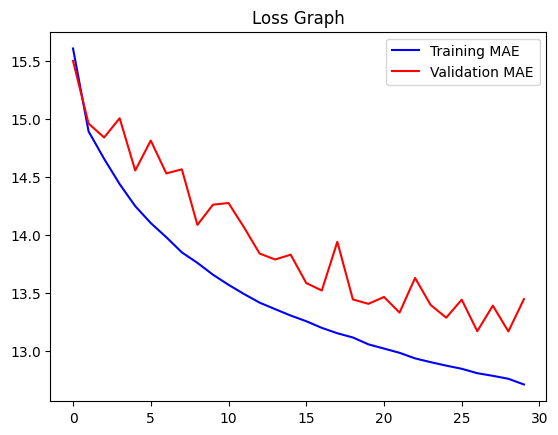

In [15]:
# Loss visualization
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Age: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted Age: 31


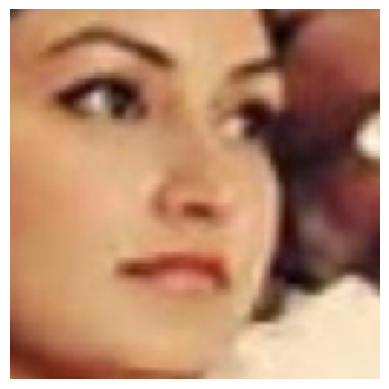

In [21]:
# Predict
image_index = 20
print("Original Age:", y_test[image_index])
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 3))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index]);
plt.show()

Original Age: 41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Predicted Age: 38


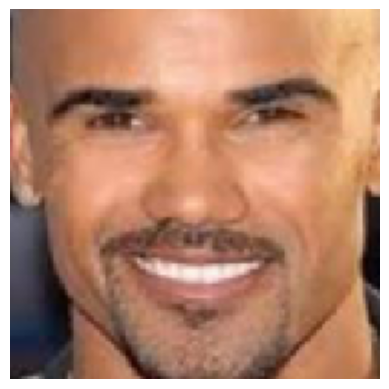

In [22]:
# Predict
image_index = 50
print("Original Age:", y_test[image_index])
pred = model.predict(X_test[image_index].reshape(1, 128, 128, 3))
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X_test[image_index]);
plt.show()

In [23]:
# Save the trained model
model.save('age_detection_model.h5')
print("Model saved as .h5 file")

Model saved as .h5 file


In [24]:
# Save architecture as JSON
model_json = model.to_json()
with open("age_detection_model.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved as JSON")

Model architecture saved as JSON


In [26]:
model.save_weights('age_detection.weights.h5')
print("Model weights saved as .h5 file")

Model weights saved as .h5 file
